In [52]:
# import packages and data
import numpy as np
import pandas as pd
import os
import seaborn as sns
import Bio
import matplotlib.pyplot as plt
import ast
import scipy.stats as stats
from scipy.optimize import curve_fit
import pickle
import numpy as np
from scipy.stats import wilcoxon

path: str = './data/'
prokaryotes_all: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_all.csv"), dtype=str)
prokaryotes_values: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_funct.csv"), dtype=str)
prokaryotes_lysate: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_322columns.csv"))

prokaryotes_values['a_point'] = prokaryotes_values['a_point'].astype('float64')
prokaryotes_values['b_point'] = prokaryotes_values['b_point'].astype('float64')
prokaryotes_values['plateau'] = prokaryotes_values['plateau'].astype('float64')
prokaryotes_values['meltPoint'] = prokaryotes_values['meltPoint'].astype('float64')

mutated_proteins: pd.DataFrame = pd.read_csv(os.path.join(path, "Essential_proteins_prediction_merged.csv"), dtype=str)
mutated_proteins['meltPoint_x'] = mutated_proteins['meltPoint_x'].astype('float64')
mutated_proteins['WT_prediction'] = mutated_proteins['WT_prediction'].astype('float64')
mutated_proteins['Mut_prediction'] = mutated_proteins['Mut_prediction'].astype('float64')
mutated_proteins['WT_diff'] = mutated_proteins['WT_diff'].astype('float64')
mutated_proteins['Mut_diff'] = mutated_proteins['Mut_diff'].astype('float64')
mutated_proteins['error_WTpred'] = mutated_proteins['WT_prediction'] - mutated_proteins['meltPoint_x']

C:\Users\tobia\AppData\Local\Temp\ipykernel_14228\3790463934.py:18: DtypeWarning: Columns (6,19,20,21,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  prokaryotes_lysate: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_322columns.csv"))


Solving of curve equation for f(T90) = 0.1 and value is stored as a new column in the prokaryotes_lysate data frame. 

In [53]:
def curve_equation(x, a, b, plateau, target):
    rel_amount = ((1-plateau)/(1+(np.power(np.e, (-a/x)+b)))) + plateau
    return rel_amount - target
from scipy.optimize import fsolve
prokaryotes_values['T90'] = pd.Series(prokaryotes_values.index).apply(lambda i: fsolve(curve_equation, prokaryotes_values.loc[i, 'meltPoint'], args=(prokaryotes_values.loc[i,'a_point'], prokaryotes_values.loc[i,'b_point'], prokaryotes_values.loc[i,'plateau'], 0.1)))
prokaryotes_lysate = prokaryotes_lysate.merge(prokaryotes_values, on= 'Protein_ID', how = 'left')

C:\Users\tobia\AppData\Local\Temp\ipykernel_14228\2636654243.py:5: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  prokaryotes_values['T90'] = pd.Series(prokaryotes_values.index).apply(lambda i: fsolve(curve_equation, prokaryotes_values.loc[i, 'meltPoint'], args=(prokaryotes_values.loc[i,'a_point'], prokaryotes_values.loc[i,'b_point'], prokaryotes_values.loc[i,'plateau'], 0.1)))


Filtering of data frame for essential proteins with +1.5° C and -1.5° C of the maximal growth temperature (Tmax) around the T90 value. The following Tmax values for each organism were obtained from literature:

Bacillus subtilis: 55°C​<br/>
Escherichia coli: 45°C<br/>
Oleispira antarctica: 28°C<br/>
Picrophilus torridus: 66°C<br/>
Thermus thermophilus: 82°C<br/>

In [54]:
# Conditions for filtering the DataFrame
conditions = [
    (prokaryotes_lysate['run_name'] == 'Bacillus subtilis_168_lysate_R1') & (prokaryotes_lysate['T90'].between(53.5, 56.5)),
    (prokaryotes_lysate['run_name'] == 'Thermus thermophilus HB27 lysate') & (prokaryotes_lysate['T90'].between(80.5, 83.5)),
    (prokaryotes_lysate['run_name'] == 'Escherichia coli lysate') & (prokaryotes_lysate['T90'].between(43.5, 46.5)),
    (prokaryotes_lysate['run_name'] == 'Picrophilus torridus DSM9790 lysate') & (prokaryotes_lysate['T90'].between(64.5, 67.5)),
    (prokaryotes_lysate['run_name'] == 'Oleispira antarctica_RB-8_lysate_R1') & (prokaryotes_lysate['T90'].between(26.5, 29.5))
]
# Combine all conditions using bitwise OR
combined_condition = conditions[0]
for condition in conditions[1:]:
    combined_condition |= condition
# Filter the DataFrame based on the combined condition

essential_proteins = prokaryotes_lysate[combined_condition].reset_index(drop=True)
essential_proteins = essential_proteins.drop_duplicates(subset='Protein_ID', keep='first')
essential_proteins = essential_proteins[['Protein_ID', 'Organism', 'Protein names', 'meltPoint_x', 'AlphaFoldDB', 'PDB', 'Sequence', 'T90', 'Gene Ontology (biological process)']]
essential_proteins['Gene Ontology (biological process)'] = essential_proteins['Gene Ontology (biological process)'].str.split(';').str[0]
essential_proteins.to_csv(os.path.join(path, 'essential_proteins.csv'), index=False)

Grouping of all essential proteins based on the 5 groups aquired through checking common linked words in the GO category of biological processes:
- Protein Transport/Folding 
- Metabolism
- Transcription/Translation
- DNA Replication/Repair
- Cell division/cycle

In [55]:
for i in essential_proteins.index:
    essential_proteins['Gene Ontology (biological process)'] = essential_proteins['Gene Ontology (biological process)'].fillna('Unknown')
    if any(word in essential_proteins.loc[i, 'Gene Ontology (biological process)'] for word in ['transport', 'localization', 'protein', 'chaperone', 'assembly']):
        essential_proteins.loc[i, 'Gene Ontology (biological process)_obscure'] = 'Protein Transport/Folding'
    elif any(word in essential_proteins.loc[i, 'Gene Ontology (biological process)'] for word in ['metabolism', 'biosynthesis', 'catabolism', 'metabolic', 'anabolism', 'glycolysis', 'glycolytic', 'glucose', 'catabolic', 'biosynthetic', 'synthesis', 'carbon', 'fixation', 'respiration', 'salvage', 'gluconeogenesis', 'beta-oxidation']):
        essential_proteins.loc[i, 'Gene Ontology (biological process)_obscure'] = 'Metabolism'
    elif any(word in essential_proteins.loc[i, 'Gene Ontology (biological process)'] for word in ['RNA', 'transcription', 'translation', 'ribosome', 'mRNA', 'tRNA', 'rRNA', 'snoRNA', 'snRNA', 'siRNA', 'piRNA']):
        essential_proteins.loc[i, 'Gene Ontology (biological process)_obscure'] = 'Transcription/Translation'
    elif any(word in essential_proteins.loc[i, 'Gene Ontology (biological process)'] for word in ['replication', 'repair', 'damage', 'nucleotide', 'methylation']):
        essential_proteins.loc[i, 'Gene Ontology (biological process)_obscure'] = 'DNA Replication/Repair'
    elif any(word in essential_proteins.loc[i, 'Gene Ontology (biological process)'] for word in ['cell', 'division', 'cycle', 'growth', 'cellular', 'mitosis', 'meiosis', 'cytokinesis', 'chromosome', 'spindle', 'centrosome', 'centriole', 'centromere', 'kinetochore', 'telomere', 'nucleus', 'nuclear', 'nucleolus']):
        essential_proteins.loc[i, 'Gene Ontology (biological process)_obscure'] = 'Cell Division/Cycle'
    elif essential_proteins.loc[i, 'Gene Ontology (biological process)'] != 'Unknown':
        essential_proteins.loc[i, 'Gene Ontology (biological process)_obscure'] = 'Other'

essential_go = essential_proteins.loc[:, ['Protein names', 'Gene Ontology (biological process)_obscure', 'Gene Ontology (biological process)','Organism']]

Plotting a bar plot of counts of essential proteins for each GO category for E.coli and B.subtilis

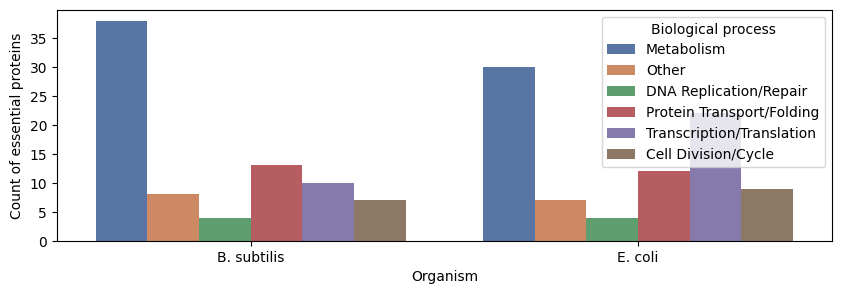

<Figure size 640x480 with 0 Axes>

In [5]:
plt.figure(figsize=(10, 3))
sns.countplot(data=essential_proteins[essential_proteins['Organism'].isin(['Bacillus subtilis (strain 168)', 'Escherichia coli (strain K12)'])], x='Organism', hue='Gene Ontology (biological process)_obscure', palette='deep')
plt.xticks(ticks=plt.gca().get_xticks(), labels= ['B. subtilis', 'E. coli'])
plt.ylabel('Count of essential proteins')
plt.legend(title='Biological process')
plt.show()
plt.savefig('./data/essentialproteinsgraph.svg',format = 'svg', dpi =1000)


C:\Users\tobia\AppData\Local\Temp\ipykernel_14228\2609285788.py:3: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.countplot(data=essential_proteins[essential_proteins['Organism'].isin(['Bacillus subtilis (strain 168)', 'Escherichia coli (strain K12)'])], x='Organism', hue='Gene Ontology (biological process)_obscure', palette=pppalette, zorder = 2)


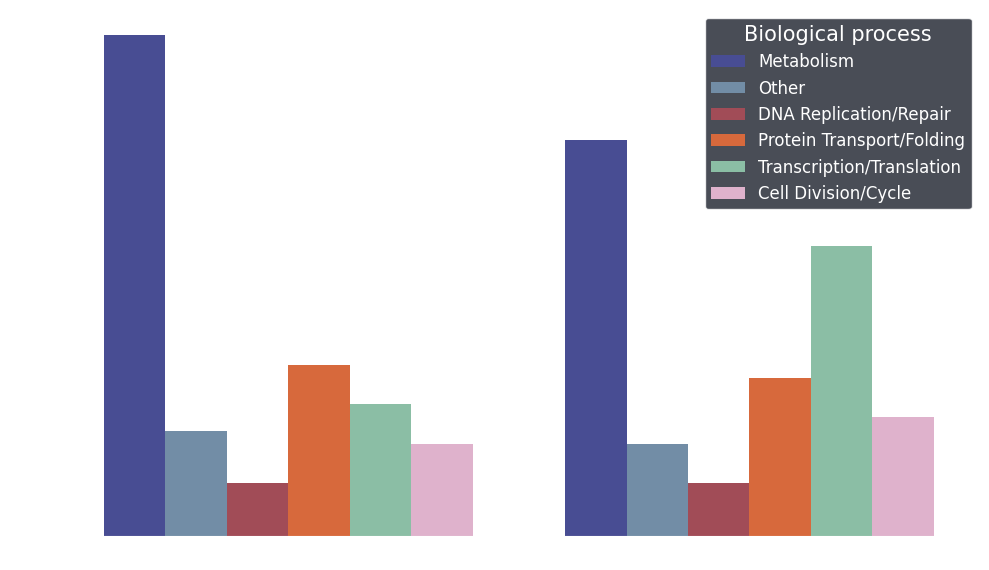

In [51]:
#same plot for powerpoint
pppalette = ['#3b429f', '#6a8eae', '#AF3E4D', '#F15E22','#82C7A5', '#e6aace','#1B212C']
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=essential_proteins[essential_proteins['Organism'].isin(['Bacillus subtilis (strain 168)', 'Escherichia coli (strain K12)'])], x='Organism', hue='Gene Ontology (biological process)_obscure', palette=pppalette, zorder = 2)
plt.xticks(ticks=plt.gca().get_xticks(), labels= ['B. subtilis', 'E. coli'], color = 'white')
plt.ylabel('Count of essential proteins', fontsize = 11, color = 'white')
#legend = plt.legend(title='Biological process', bbox_to_anchor=(1.05, 1), loc='upper left', facecolor='lightgrey',fontsize = 12, title_fontsize = 14)
plt.tight_layout()
plt.xlabel('').set_visible(False)
legend = plt.legend(title='Biological process', fontsize=12, title_fontsize=15, facecolor=pppalette[6], edgecolor = 'white',loc='upper right')
for text in legend.get_texts():
    text.set_color('white')
legend.get_title().set_color('white')
ax.spines['top'].set_color('white')  
ax.spines['right'].set_color('white') 
ax.spines['left'].set_color('white')  
ax.spines['bottom'].set_color('white')
ax.tick_params(axis='x', colors='white') 
ax.tick_params(axis='y', colors='white')  
plt.grid(alpha=0.2, color='white',zorder = 0)
plt.savefig('./data/figs/essentialproteinsgraphppt.svg',format = 'svg', dpi =1000, transparent = True)
plt.show()